In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)

In [14]:
def slice_dataset(dataset, percentage):
    data_size = len(dataset)
    return dataset[:int(data_size*percentage/100)]

def make_dataset(dataset, n_bus):
    x_raw_1, y_raw_1 = [], []
    x_raw, y_raw = [], []

    for i in range(len(dataset)):
        for n in range(n_bus):
            x_raw_1.extend(dataset[i, 4*n+1:4*n+3])
            y_raw_1.extend(dataset[i, 4*n+3:4*n+5])
        x_raw.append(x_raw_1)
        y_raw.append(y_raw_1)
        x_raw_1, y_raw_1 = [], []
        
    x_raw = torch.tensor(x_raw, dtype=torch.float)
    y_raw = torch.tensor(y_raw, dtype=torch.float)
    return x_raw, y_raw

def normalize_dataset(x, y):
    x_mean = torch.mean(x,0)
    y_mean = torch.mean(y,0)
    x_std = torch.std(x,0)
    y_std = torch.std(y,0)
    x_norm = (x-x_mean)/x_std
    y_norm = (y-y_mean)/y_std
    x_norm = torch.where(torch.isnan(x_norm), torch.zeros_like(x_norm), x_norm)
    y_norm = torch.where(torch.isnan(y_norm), torch.zeros_like(y_norm), y_norm)
    x_norm = torch.where(torch.isinf(x_norm), torch.zeros_like(x_norm), x_norm)
    y_norm = torch.where(torch.isinf(y_norm), torch.zeros_like(y_norm), y_norm)
    return x_norm, y_norm, x_mean, y_mean, x_std, y_std

def denormalize_output(y_norm, y_mean, y_std):
    y = y_norm*y_std+y_mean
    return y

def NRMSE(yhat,y):
    return torch.sqrt(torch.mean(((yhat-y)/torch.std(yhat,0))**2))

def MSE(yhat,y):
    return torch.mean((yhat-y)**2)

In [27]:
dataset1 = pd.read_excel('dataset\Grid_14 bus_1.xlsx').values
dataset2 = pd.read_excel('dataset\Grid_14 bus_2.xlsx').values

In [28]:
train_percentage = 100
val_percentage = 100

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 14

#actual data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

#normalized data
x_norm_train, y_norm_train, _, _, _, _ = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

In [29]:
class My_NN(torch.nn.Module):
    def __init__(self, input_size=None, hidden_size1=None, hidden_size2=None, output_size=None):
        super(My_NN, self).__init__()
        self.input_size = input_size if input_size is not None else 18 
        self.hidden_size1 = hidden_size1 if hidden_size1 is not None else 38
        self.hidden_size2 = hidden_size2 if hidden_size2 is not None else 38
        self.output_size = output_size if output_size is not None else 18
        
        self.lin1 = Linear(self.input_size, self.hidden_size1)
        self.lin2 = Linear(self.hidden_size1, self.hidden_size2)
        self.lin3 = Linear(self.hidden_size2, self.output_size)

    def forward(self, x):
        
        x = self.lin1(x)
        x = torch.tanh(x)

        x = self.lin2(x)
        x = torch.tanh(x)

        x = self.lin3(x)

        return x
    
    def save_weights(self, model, name):
        torch.save(model, name)

In [30]:
%%time

input_size = n_bus*2
hidden_size1 = 30
hidden_size2 = 30
output_size = n_bus*2
lr = 0.001

model = My_NN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loss_list, val_loss_list = [], []

count=0
patience=10000
lossMin = 1e10

for epoch in range(10001):

    model.train()
    optimizer.zero_grad()
    y_train_prediction = model(x_norm_train)
    train_loss = MSE(denormalize_output(y_train_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_train, y_val_mean, y_val_std))
    train_loss.backward()
    optimizer.step()
    train_loss_list.append(train_loss.detach())

    model.eval()
    y_val_prediction = model(x_norm_val)
    val_loss = MSE(denormalize_output(y_val_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_val, y_val_mean, y_val_std))
    val_loss_list.append(val_loss.detach())

    #early stopping
    if (val_loss < lossMin):
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss
        model.save_weights(model, "[PyG] [14 bus] Best_NN_model.pt")
    else:
        count+=1
        if(count>patience):
            print("early stop at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
            print("best val at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(best_epoch, best_train_loss, best_val_loss))
            break
    
    #if (train_loss <= 0):
    #    print("min train loss at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
    #    break

    if (epoch % 10) == 0:
        print('epoch: {:d}    train loss: {:.7f}    val loss: {:.7f}'.format(epoch, train_loss, val_loss))

epoch: 0    train loss: 0.3544139    val loss: 0.3500614
epoch: 10    train loss: 0.3186767    val loss: 0.3159057
epoch: 20    train loss: 0.2727171    val loss: 0.2701104
epoch: 30    train loss: 0.2071412    val loss: 0.2039799
epoch: 40    train loss: 0.1276366    val loss: 0.1245110
epoch: 50    train loss: 0.0614628    val loss: 0.0599505
epoch: 60    train loss: 0.0307530    val loss: 0.0302672
epoch: 70    train loss: 0.0208093    val loss: 0.0198023
epoch: 80    train loss: 0.0167030    val loss: 0.0158139
epoch: 90    train loss: 0.0151878    val loss: 0.0145732
epoch: 100    train loss: 0.0140068    val loss: 0.0134536
epoch: 110    train loss: 0.0129689    val loss: 0.0124188
epoch: 120    train loss: 0.0120168    val loss: 0.0115251
epoch: 130    train loss: 0.0111431    val loss: 0.0107224
epoch: 140    train loss: 0.0103312    val loss: 0.0099432
epoch: 150    train loss: 0.0095719    val loss: 0.0092016
epoch: 160    train loss: 0.0088665    val loss: 0.0085237
epoch: 1

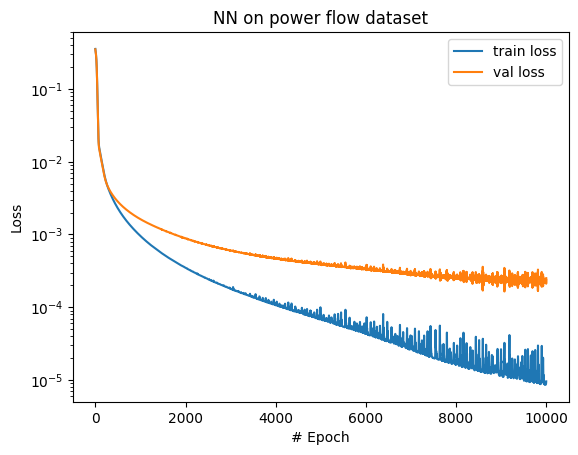

last epoch: 10000, train loss: 0.0000096, val loss: 0.0002509
best epoch: 9073, train loss: 0.0000324, val loss: 0.0001645


In [31]:
plt.title('NN on power flow dataset')
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.yscale('log')
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

print('last epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(epoch, train_loss, val_loss))
print('best epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(best_epoch, best_train_loss, best_val_loss))

In [32]:
for name, param in model.named_parameters():
  print(name)
  print(param.size())

param = sum(p.numel() for p in model.parameters() if p.requires_grad)
param

lin1.weight
torch.Size([30, 28])
lin1.bias
torch.Size([30])
lin2.weight
torch.Size([30, 30])
lin2.bias
torch.Size([30])
lin3.weight
torch.Size([28, 30])
lin3.bias
torch.Size([28])


2668

In [33]:
model.eval()

y_train_prediction = model(x_norm_train)
train_loss = MSE(denormalize_output(y_train_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_train, y_val_mean, y_val_std))
print("Train output ground-truth: \n" + str(y_raw_train.detach().numpy()[0]))
print("Train output prediction: \n" + str(denormalize_output(y_train_prediction, y_val_mean, y_val_std).detach().numpy()[0]))
print('Train loss (MSE): {:.7f}'.format(train_loss))

print("===========================================================================")

y_val_prediction = model(x_norm_val)
val_loss = MSE(denormalize_output(y_val_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_val, y_val_mean, y_val_std))
print("Train output ground-truth: \n" + str(y_raw_val.detach().numpy()[0]))
print("Train output prediction: \n" + str(denormalize_output(y_val_prediction, y_val_mean, y_val_std).detach().numpy()[0]))
print('Train loss (MSE): {:.7f}'.format(val_loss))

Train output ground-truth: 
[  10.324 -154.216    9.882 -156.117    9.753 -156.712    9.724 -156.839
    9.659 -157.161    9.607 -157.399    9.617 -157.37     9.627 -157.311
    9.581 -157.512    9.56  -157.633    9.773 -156.613    9.682 -157.039
    9.658 -157.152    9.664 -157.123]
Train output prediction: 
[  10.32369 -154.21858    9.88141 -156.11742    9.75225 -156.71446
    9.72426 -156.83875    9.65715 -157.16441    9.60591 -157.39868
    9.61655 -157.37032    9.62467 -157.31735    9.58032 -157.5144
    9.55804 -157.63274    9.77152 -156.61739    9.68221 -157.04497
    9.65724 -157.16107    9.66321 -157.13039]
Train loss (MSE): 0.0000100
Train output ground-truth: 
[  10.302 -154.788    9.844 -156.745    9.686 -157.465    9.685 -157.484
    9.574 -157.989    9.568 -158.053    9.543 -158.141    9.532 -158.187
    9.518 -158.294    9.535 -158.209    9.727 -157.275    9.629 -157.731
    9.599 -157.869    9.594 -157.896]
Train output prediction: 
[  10.30192 -154.78087    9.84362 -15

In [34]:
best_model = torch.load("[PyG] [14 bus] Best_NN_model.pt")
best_model.eval()

y_train_prediction = best_model(x_norm_train)
train_loss = MSE(denormalize_output(y_train_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_train, y_val_mean, y_val_std))
print("Train output ground-truth: \n" + str(y_raw_train.detach().numpy()[0]))
print("Train output prediction: \n" + str(denormalize_output(y_train_prediction, y_val_mean, y_val_std).detach().numpy()[0]))
print('Train loss (MSE): {:.7f}'.format(train_loss))

print("===========================================================================")

y_val_prediction = best_model(x_norm_val)
val_loss = MSE(denormalize_output(y_val_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_val, y_val_mean, y_val_std))
print("Train output ground-truth: \n" + str(y_raw_val.detach().numpy()[0]))
print("Train output prediction: \n" + str(denormalize_output(y_val_prediction, y_val_mean, y_val_std).detach().numpy()[0]))
print('Train loss (MSE): {:.7f}'.format(val_loss))

Train output ground-truth: 
[  10.324 -154.216    9.882 -156.117    9.753 -156.712    9.724 -156.839
    9.659 -157.161    9.607 -157.399    9.617 -157.37     9.627 -157.311
    9.581 -157.512    9.56  -157.633    9.773 -156.613    9.682 -157.039
    9.658 -157.152    9.664 -157.123]
Train output prediction: 
[  10.32379 -154.21645    9.88181 -156.11435    9.75239 -156.71124
    9.72461 -156.83609    9.65717 -157.16106    9.60601 -157.39635
    9.61664 -157.36684    9.62476 -157.31421    9.58045 -157.51187
    9.55803 -157.63058    9.77198 -156.61409    9.68322 -157.04146
    9.65793 -157.15793    9.66377 -157.12694]
Train loss (MSE): 0.0000310
Train output ground-truth: 
[  10.302 -154.788    9.844 -156.745    9.686 -157.465    9.685 -157.484
    9.574 -157.989    9.568 -158.053    9.543 -158.141    9.532 -158.187
    9.518 -158.294    9.535 -158.209    9.727 -157.275    9.629 -157.731
    9.599 -157.869    9.594 -157.896]
Train output prediction: 
[  10.30151 -154.78867    9.84268 -1

C:\Users\panka\AppData\Local\Temp\ipykernel_3160\4246943532.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("[PyG] [14 bus] Best_NN_model.pt")


In [35]:
%%time

best_model = torch.load("[PyG] [14 bus] Best_NN_model.pt")
best_model.eval()

test_loss_list = []

for i in range(102):
    
    dataset = pd.read_excel('dataset\Grid_14 bus_%d.xlsx' % (i+1)).values
    test_percentage = 100
    test_dataset = slice_dataset(dataset, test_percentage)
    x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)
    x_norm_test, y_norm_test, _, _, _, _ = normalize_dataset(x_raw_test, y_raw_test)
    
    print('dataset {:d}'.format(i+1))
    
    y_test_prediction = best_model(x_norm_test)
    test_loss = MSE(denormalize_output(y_test_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_test, y_val_mean, y_val_std))
    
    if i == 0:
        print('Train loss (MSE): {:.7f}'.format(test_loss.detach().numpy()))
    elif i == 1:
        print('Val loss (MSE): {:.7f}'.format(test_loss.detach().numpy()))
    else:
        print('Test loss (MSE): {:.7f}'.format(test_loss))
        test_loss_list.append(test_loss.detach().numpy())
    
    print("===========================")

column = []
for i in range(100):
    column.append('test loss %d' % (i+1))
    
test_loss_file = pd.DataFrame([test_loss_list], columns=column)
test_loss_file.to_excel("[PyG] [14 bus] [MSE] NN test loss.xlsx")
print("\ntest loss file saved!\n")

<timed exec>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


dataset 1
Train loss (MSE): 0.0000310
dataset 2
Val loss (MSE): 0.0001645
dataset 3
Test loss (MSE): 0.0000624
dataset 4
Test loss (MSE): 0.0001228
dataset 5
Test loss (MSE): 0.0002107
dataset 6
Test loss (MSE): 0.0000645
dataset 7
Test loss (MSE): 0.0001044
dataset 8
Test loss (MSE): 0.0002375
dataset 9
Test loss (MSE): 0.0001166
dataset 10
Test loss (MSE): 0.0001733
dataset 11
Test loss (MSE): 0.0001061
dataset 12
Test loss (MSE): 0.0003793
dataset 13
Test loss (MSE): 0.0000728
dataset 14
Test loss (MSE): 0.0000769
dataset 15
Test loss (MSE): 0.0001008
dataset 16
Test loss (MSE): 0.0000672
dataset 17
Test loss (MSE): 0.0000689
dataset 18
Test loss (MSE): 0.0001171
dataset 19
Test loss (MSE): 0.0001006
dataset 20
Test loss (MSE): 0.0002888
dataset 21
Test loss (MSE): 0.0001931
dataset 22
Test loss (MSE): 0.0001410
dataset 23
Test loss (MSE): 0.0000894
dataset 24
Test loss (MSE): 0.0000901
dataset 25
Test loss (MSE): 0.0001103
dataset 26
Test loss (MSE): 0.0001004
dataset 27
Test loss 

In [36]:
%%time

best_model = torch.load("[PyG] [14 bus] Best_NN_model.pt")
best_model.eval()

test_loss_list = []

for i in range(102):
    
    dataset = pd.read_excel('dataset\Grid_14 bus_%d.xlsx' % (i+1)).values
    test_percentage = 100
    test_dataset = slice_dataset(dataset, test_percentage)
    x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)
    x_norm_test, y_norm_test, _, _, _, _ = normalize_dataset(x_raw_test, y_raw_test)
    
    print('dataset {:d}'.format(i+1))
    
    yhat = denormalize_output(best_model(x_norm_test), y_val_mean, y_val_std)
    y = y_raw_test
    test_loss_NRMSE = NRMSE(yhat, y)
    
    if i == 0:
        print('Train loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
    elif i == 1:
        print('Val loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
    else:
        print('Test loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
        test_loss_list.append(test_loss_NRMSE.detach().numpy())
    
    print("===========================")

column = []
for i in range(100):
    column.append('test loss %d' % (i+1))
    
test_loss_file = pd.DataFrame([test_loss_list], columns=column)
test_loss_file.to_excel("[PyG] [14 bus] [NRMSE] NN test loss.xlsx")
print("\ntest loss file saved!\n")

<timed exec>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


dataset 1
Train loss (NRMSE): 0.0216876
dataset 2
Val loss (NRMSE): 0.0239578
dataset 3
Test loss (NRMSE): 0.0235791
dataset 4
Test loss (NRMSE): 0.0270352
dataset 5
Test loss (NRMSE): 0.0288369
dataset 6
Test loss (NRMSE): 0.0229688
dataset 7
Test loss (NRMSE): 0.0500858
dataset 8
Test loss (NRMSE): 0.0683891
dataset 9
Test loss (NRMSE): 0.0281425
dataset 10
Test loss (NRMSE): 0.0561699
dataset 11
Test loss (NRMSE): 0.0431392
dataset 12
Test loss (NRMSE): 0.0362823
dataset 13
Test loss (NRMSE): 0.0237799
dataset 14
Test loss (NRMSE): 0.0254754
dataset 15
Test loss (NRMSE): 0.0264731
dataset 16
Test loss (NRMSE): 0.0306039
dataset 17
Test loss (NRMSE): 0.0310007
dataset 18
Test loss (NRMSE): 0.0379744
dataset 19
Test loss (NRMSE): 0.0282973
dataset 20
Test loss (NRMSE): 0.0293100
dataset 21
Test loss (NRMSE): 0.0386898
dataset 22
Test loss (NRMSE): 0.0341554
dataset 23
Test loss (NRMSE): 0.0330937
dataset 24
Test loss (NRMSE): 0.0572399
dataset 25
Test loss (NRMSE): 0.0405866
dataset 2